# Google Maps API

In this section, we demonstrate how to use the Google Maps Distance Matrix API and Places API using the `googlemaps` library in Python.

Prerequisites:


*   Get API key: https://developers.google.com/maps/documentation/javascript/get-api-key#console
*   Install `googlemaps` library: `!pip install googlemaps`.



In [ ]:
!pip install googlemaps

  Preparing metadata (setup.py) ... done
  Created wheel for googlemaps: filename=googlemaps-4.10.0-py3-none-any.whl size=40715 sha256=72715701941de296ef4e52d2c64716bd9483db0636128fb586509eb65a524f49
  Stored in directory: /root/.cache/pip/wheels/f1/09/77/3cc2f5659cbc62341b30f806aca2b25e6a26c351daa5b1f49a
Successfully built googlemaps


In [ ]:
from google.colab import userdata
mykey = userdata.get('GMAP_KEY')

In [ ]:
import googlemaps

# Replace with your actual API Key
# API_KEY = "YOUR_KEY"
API_KEY = mykey

# Initialize client
gmaps = googlemaps.Client(key=API_KEY)


## Distance Matrix API
The Distance Matrix API returns travel distance and time for a matrix of origins and destinations.

Reference: https://developers.google.com/maps/documentation/distance-matrix/overview

In [ ]:
# Example: Distance and duration between two locations
origin = "Los Angeles, CA"
destination = "San Francisco, CA"

distance_result = gmaps.distance_matrix(origins=[origin],
                                        destinations=[destination],
                                        mode='driving')

# Let's parse the result
rows = distance_result['rows']
elements = rows[0]['elements']
distance_text = elements[0]['distance']['text']
duration_text = elements[0]['duration']['text']

print(f"Distance from {origin} to {destination}: {distance_text}")
print(f"Estimated travel time: {duration_text}")


Distance from Los Angeles, CA to San Francisco, CA: 615 km
Estimated travel time: 5 hours 55 mins


## Places API
The Places API allows you to query for detailed information about local businesses, points of interest, etc.

Reference: https://developers.google.com/maps/documentation/places/web-service

In [ ]:
# Example: Searching for coffee shops near a specific location
# Coordinates for Manhattan, New York (lat, lng)


search_result = gmaps.places_nearby(location=location,
                                    radius=500,
                                    type='cafe')

for place in search_result['results'][:5]:  # Show top 5
    name = place['name']
    rating = place.get('rating', 'N/A')
    address = place.get('vicinity', 'N/A')
    print(f"Name: {name}, Rating: {rating}, Address: {address}")


Name: The Red Flame, Rating: 4.2, Address: 67 West 44th Street, New York
Name: Stand Up NY at Bond 45, Rating: 4.2, Address: 221 West 46th Street, New York
Name: Gregorys Coffee, Rating: 4.2, Address: 58 West 44th Street, New York
Name: Dunkin', Rating: 4.1, Address: 240 West 40th Street, New York
Name: McDonald's, Rating: 3.6, Address: 1188 6th Avenue, New York


# Toy Classification (MNIST)

We will train a simple multilayer perceptron (MLP) on the MNIST dataset. To illustrate how to customize your own network, we'll use JAX (since it is quite simple with Flax and only requires a few lines), but you could adapt the idea to PyTorch or TensorFlow easily.

In [ ]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

# Download and load the MNIST dataset (we'll just reuse TorchVision for convenience)
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 52.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.65MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 12.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.67MB/s]


In [ ]:
import jax
import jax.numpy as jnp
from flax import linen as nn

# A simple MLP with one hidden layer
class SimpleMLP(nn.Module):
    features: int = 128

    @nn.compact
    def __call__(self, x):
        # Flatten input from (batch, 1, 28, 28) to (batch, 784)
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(features=self.features)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)  # 10 classes for MNIST
        return x

In [ ]:


import optax
# Create model and optimizer
model = SimpleMLP()
rng = jax.random.PRNGKey(0)
sample_input = jnp.ones((1, 1, 28, 28), jnp.float32)
params = model.init(rng, sample_input)['params']

optimizer = optax.sgd(learning_rate=0.01)
opt_state = optimizer.init(params)


Epoch 1, last batch loss: 0.5481
Epoch 2, last batch loss: 0.6616


In [ ]:
@jax.jit
def train_step(params, opt_state, batch):
    images, labels = batch

    def loss_fn(params):
        logits = model.apply({'params': params}, images)
        one_hot = jax.nn.one_hot(labels, 10)
        loss = optax.softmax_cross_entropy(logits, one_hot).mean()
        return loss, logits

    (loss, logits), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [ ]:
# Training loop (very simple, just a few steps)
import numpy as np

num_epoch = 2
for epoch in range(1, 1 + num_epoch):  # 2 epochs for illustration
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = np.array(images, dtype=np.float32)
        labels = np.array(labels, dtype=np.int32)
        params, opt_state, loss_val = train_step(params, opt_state, (images, labels))
    print(f"Epoch {epoch}, last batch loss: {loss_val:.4f}")


In [ ]:
@jax.jit
def apply_model(params, images):
    return model.apply({'params': params}, images)

correct = 0
total = 0
for images, labels in test_loader:
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)
    logits = apply_model(params, images)
    predictions = jnp.argmax(logits, axis=1)
    correct += jnp.sum(predictions == labels)
    total += labels.shape[0]

accuracy = 100.0 * correct.item() / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 90.13%


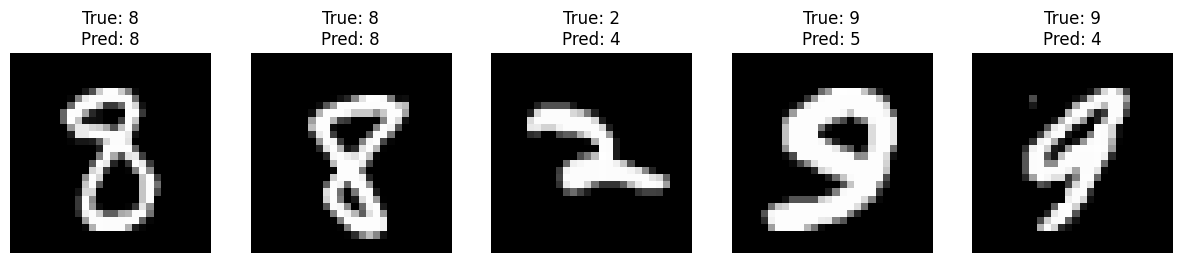

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample a few images from the test set
num_samples = 5
sample_indices = np.random.choice(len(test_dataset), num_samples, replace=False)

fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

for i, idx in enumerate(sample_indices):
  image, label = test_dataset[idx]
  image = np.array(image, dtype=np.float32)
  logits = apply_model(params, np.expand_dims(image, axis=0))
  predicted_label = np.argmax(logits)

  axes[i].imshow(image.squeeze(), cmap='gray')
  axes[i].set_title(f"True: {label}\nPred: {predicted_label}")
  axes[i].axis('off')

plt.show()

# Toy Generative (MNIST, Fine-tuning Pretrained Diffusion with Flax + Accelerate)

We'll demonstrate a simple Diffusion model training setup using [Hugging Face Diffusers](https://github.com/huggingface/diffusers). While `diffusers` often focuses on more complex image generation, we can adapt it for simpler cases. Note that training a diffusion model can be computationally heavy, but we'll keep a minimal example.

In this section, instead of training a diffusion model from scratch, we will show how to fine-tune a small, pretrained diffusion model using Flax (JAX-based) and Accelerate for easier multi-device or single-device training.

First we need to have HF_TOKEN: https://huggingface.co/settings/tokens


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from diffusers import UNet2DModel, DDPMScheduler
from accelerate import Accelerator
import torch.nn.functional as F
import torch.optim as optim

# Initialize Accelerator
accelerator = Accelerator(mixed_precision="fp16")
device = accelerator.device

# Transform and dataset
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # scale to [-1, 1]
])

train_dataset = datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

# Model, scheduler, optimizer
model = UNet2DModel.from_pretrained("google/ddpm-cifar10-32")
scheduler = DDPMScheduler.from_pretrained("google/ddpm-cifar10-32")
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Prepare everything with Accelerator
model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)



100%|██████████| 170M/170M [00:04<00:00, 34.4MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/143M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

In [ ]:
# prompt: count number of parameters in model; all parameters not only trainable

import numpy as np
import torch
from flax import linen as nn
from diffusers import UNet2DModel

# Assuming 'model' is your Flax model (SimpleMLP or the UNet2DModel)
# or any other PyTorch model.

def count_parameters(model):
    total_params = 0
    if isinstance(model, nn.Module):
      #Flax model
      sample_input = jnp.ones((1, 1, 28, 28), jnp.float32)
      params = model.init(jax.random.PRNGKey(0), sample_input)['params']
      for param_name in params:
          total_params += params[param_name].size
    elif isinstance(model, UNet2DModel):
      #Diffusers model
      total_params = sum(p.numel() for p in model.parameters())
    elif isinstance(model, torch.nn.Module):
      #PyTorch model
      total_params = sum(p.numel() for p in model.parameters())
    else:
      print("Model type not supported for parameter counting.")

    return total_params


# Example usage:
# Assuming 'model' is the trained SimpleMLP
total_params = count_parameters(model)
print("Total number of parameters: ", total_params)

# Example usage (for the diffusers model):
#total_params_diffusers = count_parameters(model)
#print(f"Total number of parameters in the diffusion model: {total_params_diffusers}")


Total number of parameters:  35746307


In [ ]:
# Training loop
model.train()
num_epochs = 1  # Set to a small number for demo

for epoch in range(num_epochs):
    for step, (images, _) in enumerate(train_loader):
        images = images.to(device)

        # Sample random timesteps for each image
        timesteps = torch.randint(0, scheduler.num_train_timesteps, (images.shape[0],), device=device).long()

        # Add noise
        noise = torch.randn_like(images)
        noisy_images = scheduler.add_noise(images, noise, timesteps)

        # Predict the noise
        noise_pred = model(noisy_images, timesteps).sample

        # Loss: MSE between predicted and true noise
        loss = F.mse_loss(noise_pred, noise)

        accelerator.backward(loss)
        optimizer.step()
        optimizer.zero_grad()

        if step % 100 == 0:
            print(f"Epoch {epoch} | Step {step} | Loss: {loss.item():.4f}")

print("Training done!")


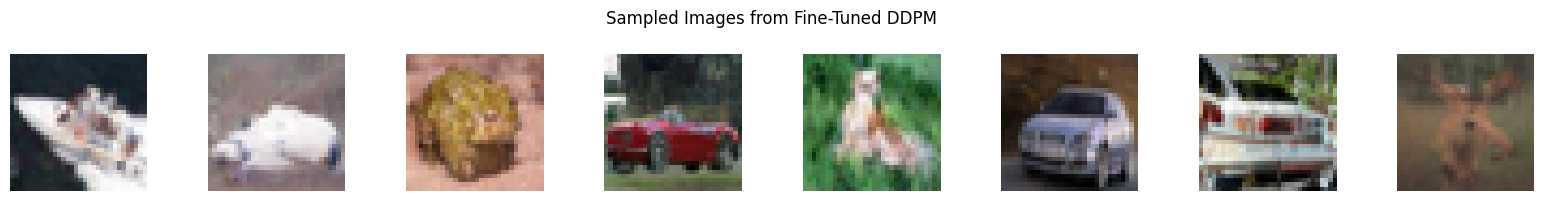

In [ ]:
import matplotlib.pyplot as plt

model.eval()
num_inference_steps = 1000
scheduler.set_timesteps(num_inference_steps)

n = 8  # how many images to sample
noise = torch.randn((n, 3, 32, 32)).to(device)

for t in scheduler.timesteps:
    with torch.no_grad():
        noise_pred = model(noise, t).sample
    noise = scheduler.step(noise_pred, t, noise).prev_sample

# Unnormalize and plot
samples = (noise.clamp(-1, 1) + 1) / 2  # back to [0, 1]
samples = samples.cpu().permute(0, 2, 3, 1)

fig, axs = plt.subplots(1, n, figsize=(n * 2, 2))
for i in range(n):
    axs[i].imshow(samples[i])
    axs[i].axis("off")
plt.suptitle("Sampled Images from Fine-Tuned DDPM")
plt.tight_layout()
plt.show()

# Temporal Model for Transit Delay Prediction (METR-LA Dataset)

We will load and model the METR-LA dataset. The official dataset can be found [here](https://drive.google.com/file/d/1pAGRfzMx6K9WWsfDcD1NMbIif0T0saFC/view). We'll demonstrate a simple LSTM and a Transformer approach in PyTorch.

## Downloading and Loading Data

In [ ]:
!pip install gdown  # if needed
# The ID is everything after 'id=' in the share link or in the final part of the URL
file_id = "1pAGRfzMx6K9WWsfDcD1NMbIif0T0saFC"
!gdown --id $file_id

# This should download a file named: metr-la.h5


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1pAGRfzMx6K9WWsfDcD1NMbIif0T0saFC
To: /content/metr-la.h5
100% 57.0M/57.0M [00:01<00:00, 53.0MB/s]


In [ ]:

import h5py

file_path = "metr-la.h5"

with h5py.File(file_path, 'r') as f:
    all_keys = list(f.keys())
    print("Top-level keys in this HDF5 file:", all_keys)

    # For each key, you can check if it's a dataset or a group
    for key in all_keys:
        item = f[key]
        if isinstance(item, h5py.Dataset):
            print(f"Dataset: {key}, shape: {item.shape}, dtype: {item.dtype}")
        elif isinstance(item, h5py.Group):
            print(f"Group: {key}")
            g = f[key]
            sub_keys = list(g.keys())
            print(f"  Keys inside group '{key}': {sub_keys}")
        else:
            print(f"Unknown type for key '{key}': {type(item)}")

Top-level keys in this HDF5 file: ['df']
Group: df
  Keys inside group 'df': ['axis0', 'axis1', 'block0_items', 'block0_values']


In [ ]:
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class METRLA(Dataset):
    def __init__(self, file_path="metr-la.h5", seq_len=12, pred_len=3):
        super().__init__()
        with h5py.File(file_path, 'r') as f:
            self.data = f['df']['block0_values'][:]
        self.seq_len = seq_len
        self.pred_len = pred_len

    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.seq_len]
        y = self.data[idx + self.seq_len : idx + self.seq_len + self.pred_len]
        # x shape: (seq_len, #sensors), y shape: (pred_len, #sensors)
        return torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.float)

train_dataset = METRLA("metr-la.h5", seq_len=12, pred_len=3)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [ ]:
train_dataset.data.shape

(34272, 207)

In [ ]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        out, _ = self.lstm(x)
        # Take the last output
        out = out[:, -1, :]  # (batch, hidden_dim)
        out = self.fc(out)   # (batch, output_dim)
        return out


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

input_dim = train_dataset.data.shape[1]  # number of sensors
hidden_dim = 64
pred_len = 3  # how many future timesteps to predict
# We might flatten sensor dimension or handle it differently.
# For simplicity, let's predict the average speed over all sensors or just a single sensor, etc.

model_lstm = LSTMModel(input_dim, hidden_dim, pred_len, num_layers=1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=1e-3)

model_lstm.train()
for epoch in range(10):
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        # x: (batch, seq_len, #sensors), y: (batch, pred_len, #sensors)
        # Option 1: Summarize or average across sensors => (batch, pred_len)
        y_agg = y.mean(dim=2)  # (batch, pred_len)

        optimizer.zero_grad()
        pred = model_lstm(x)  # (batch, pred_len)
        loss = criterion(pred, y_agg)
        loss.backward()
        optimizer.step()
    print(f"LSTM Epoch {epoch+1} - Loss: {loss.item():.4f}")


LSTM Epoch 1 - Loss: 920.1144
LSTM Epoch 2 - Loss: 171.1982


In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2, pred_len=3):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, pred_len)

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        x = self.input_proj(x)         # (batch, seq_len, d_model)
        x = x.permute(1, 0, 2)         # (seq_len, batch, d_model)
        enc_out = self.transformer_encoder(x)
        last_step = enc_out[-1]        # (batch, d_model)
        out = self.fc_out(last_step)   # (batch, pred_len)
        return out


In [ ]:
model_transformer = TransformerModel(input_dim, d_model=64, nhead=4, num_layers=2, pred_len=pred_len).to(device)
optimizer_trans = torch.optim.Adam(model_transformer.parameters(), lr=1e-3)
model_transformer.train()

for epoch in range(10):
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        y_agg = y.mean(dim=2)  # (batch, pred_len)
        optimizer_trans.zero_grad()
        pred = model_transformer(x)
        loss = criterion(pred, y_agg)
        loss.backward()
        optimizer_trans.step()
    print(f"Transformer Epoch {epoch+1} - Loss: {loss.item():.4f}")


Transformer Epoch 1 - Loss: 140.0420
Transformer Epoch 2 - Loss: 6.2438
Transformer Epoch 3 - Loss: 7.9323
Transformer Epoch 4 - Loss: 63.4798
Transformer Epoch 5 - Loss: 67.0793
Transformer Epoch 6 - Loss: 7.2835
Transformer Epoch 7 - Loss: 7.8351
Transformer Epoch 8 - Loss: 5.6226
Transformer Epoch 9 - Loss: 10.1049
Transformer Epoch 10 - Loss: 2.6663
